In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
from oggm.utils import mkdir
import oggm
import geopandas as gpd
import sys

In [6]:
model_author = 'OGGM-VAS'
gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
scenarios = ['historical','ssp126']
y0_times = [1851, 1901, 1951, 1995, 2021, 2041, 2061, 2081]

rgi_reg: 11 started
3883
3883
3883
3883
3883


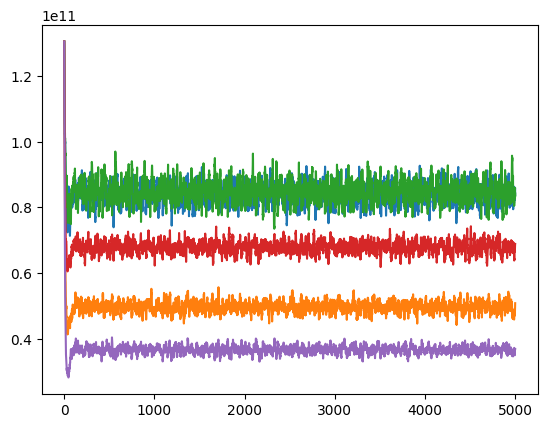

In [15]:
folder_path = f'/home/www/moberrauch/gmip3/run_output/' #RGI{rgi_reg}/{gcm}_historical_1851-1870.nc'
# https://cluster.klima.uni-bremen.de/~moberrauch/gmip3/run_output/RGI01/gfdl-esm4_historical_1851-1870.nc
for rgi_reg in ['11']:
    print(f'rgi_reg: {rgi_reg} started')
    for y0_time in [2081]:
        period = f'{y0_time}-{y0_time+19}'
        if y0_time in [1851, 1901, 1951, 1995]:
            scenarios_sel = ['historical']
        else:
            scenarios_sel = scenarios[1:]
        # just because I have to repeat the 1995 again !!!
        for scenario in scenarios_sel:
            for gcm in gcms:
                #path = folder_path + f'{rgi_reg}/{model_author}_rgi{rgi_reg}_glaciers_{period}_{gcm}_{scenario}*.nc'
                path = folder_path + f'RGI{rgi_reg}/{gcm}_{scenario}_{period}.nc'
                #try:
                #ds = xr.open_dataset(path)
                #ds = ds.load()
                #except:
                #    path = folder_path + f'RGI{rgi_reg}/{gcm}_{scenario}_{period}_stop.nc'
                #    ds = xr.open_dataset(path)
                with xr.open_dataset(path) as ds:
                    print(len(ds.isel(time=0).volume.dropna(dim='rgi_id').rgi_id))
                    ds = ds.volume.sum(dim='rgi_id').load()
                #ds_l = 100*ds/ds.isel(time=0)
                plt.plot(ds.time, ds)

In [14]:
 xr.open_dataset(path).isel(time=0)

<xarray.Dataset>
Dimensions:         (time: 5001, rgi_id: 3927)
Coordinates:
  * time            (time) float64 0.0 1.0 2.0 3.0 ... 4.998e+03 4.999e+03 5e+03
  * rgi_id          (rgi_id) object 'RGI60-11.00001' ... 'RGI60-11.03927'
    hydro_year      (time) int64 ...
    hydro_month     (time) int64 ...
    calendar_year   (time) int64 ...
    calendar_month  (time) int64 ...
Data variables:
    volume          (time, rgi_id) float32 ...
    area            (time, rgi_id) float32 ...
    length          (time, rgi_id) float32 ...
    ela             (time, rgi_id) float32 ...
    spec_mb         (time, rgi_id) float32 ...
    min_hgt         (time, rgi_id) float32 ...
    max_hgt         (time, rgi_id) float32 ...
    tau_l           (time, rgi_id) float32 ...
    tau_a           (time, rgi_id) float32 ...
    water_level     (rgi_id) float32 ...
    glen_a          (rgi_id) float32 ...
    fs              (rgi_id) float32 ...
Attributes:
    description:    OGGM model output
    oggm_version:   1.0.1.dev737+g0fd8873
    calendar:       365-day no leap
    creation_date:  2023-02-08 10:47:50

#### create fillling mechanism ... 

In [15]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
from oggm.utils import mkdir
import oggm
import geopandas as gpd
import sys

### start via: `sbatch postprocessing_fill_missing_glaciers_rounce.slurm '01' ` ...

today = '07/02/2023'
model_author = 'OGGM-VAS'
gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
scenarios = ['historical', #orical',
             'ssp126', 'ssp370','ssp585']
y0_times = [1851, 1901, 1951, 1995, 2021, 2041, 2061, 2081]

#y0_times = [2021, 2041, 2061, 2081]

#y0_times = [2021, 2041] #,
#y0_times = [2021, 2041]
#y0_times = [1995]
print(y0_times)
# get the RGI area / ITMIX volumes of the glaciers
rgi_regs = []
for rgi_reg in np.arange(1,20,1):
    if rgi_reg < 10:
        rgi_reg = '0'+str(rgi_reg)
    else:
        rgi_reg = str(rgi_reg)
    rgi_regs.append(rgi_reg)
df_itmix = pd.read_hdf(oggm.utils.get_demo_file('rgi62_itmix_df.h5'))
rgidf_dict = {}
for rgi_reg in rgi_regs:
    path_rgi = oggm.utils.get_rgi_region_file(rgi_reg, version='6')
    rgidf = gpd.read_file(path_rgi)
    #Greenland periphery : all glaciers with connectivity level 0 and 1 should be included, level 2 glaciers should be excluded (as was the case for GlacierMIP2)
    # total RGI area: 89,651km2
    if rgi_reg == '05':
        rgidf = rgidf.loc[(rgidf['Connect'] == 0) | (rgidf['Connect'] ==1)]
    rgidf_dict[rgi_reg] = rgidf
    rgidf_dict[rgi_reg] = rgidf_dict[rgi_reg].set_index('RGIId')

[1851, 1901, 1951, 1995, 2021, 2041, 2061, 2081]


In [18]:
rgi_reg_sel = '12'

In [19]:
    
#rgi_reg_sel = '01'    
### get the per glacier volumes and areas for each rgi_region, period, scenario and gcm: 
### then estimate which glaciers are missing and get the missing_vs_working rgi area
### we also have to enlarge our dataset with the missing glaciers (first just put NaN values inside, those will be filled later)
### then fill the missing glaciers with the mean statistics from glaciers with a relative glacier area difference of less than 1%
#folder_path = '/home/www/drounce/per_glacier/'
folder_path = f'/home/www/moberrauch/gmip3/run_output/' #RGI{rgi_reg}/{gcm}_historical_1851-1870.nc'
# https://cluster.klima.uni-bremen.de/~moberrauch/gmip3/run_output/RGI01/gfdl-esm4_historical_1851-1870.nc
for rgi_reg in [rgi_reg_sel]:
    print(f'rgi_reg: {rgi_reg} started')
    for y0_time in y0_times:
        period = f'{y0_time}-{y0_time+19}'
        if y0_time in [1851, 1901, 1951, 1995]:
            scenarios_sel = ['historical']
        else:
            scenarios_sel = scenarios[1:]
        # just because I have to repeat the 1995 again !!!
        for scenario in scenarios_sel:
            for gcm in gcms:
                try:
                    #path = folder_path + f'{rgi_reg}/{model_author}_rgi{rgi_reg}_glaciers_{period}_{gcm}_{scenario}*.nc'
                    path = folder_path + f'RGI{rgi_reg}/{gcm}_{scenario}_{period}.nc'
                    #try:
                    #ds = xr.open_dataset(path)
                    #ds = ds.load()
                    #except:
                    #    path = folder_path + f'RGI{rgi_reg}/{gcm}_{scenario}_{period}_stop.nc'
                    #    ds = xr.open_dataset(path)
                    ds = xr.open_dataset(path)
                    ds = ds.rename_vars({'volume':'volume_m3'})
                    ds = ds.rename_vars({'area':'area_m2'})
                    ds = ds.rename_dims({'time':'simulation_year'})
                    ds = ds[['volume_m3','area_m2']]
                    ds = ds.load()

                    rgi_reg_working = ds.volume_m3.isel(simulation_year=0).dropna(dim='rgi_id').rgi_id.values
                    #bad_rgi = []
                    #for r in rgidf_dict[rgi_reg].index:
                    #    if r not in rgi_reg_working:
                    #        bad_rgi.append(r)
                    bad_rgi = list(set(rgidf_dict[rgi_reg].index).difference(rgi_reg_working))

                    bad = rgidf_dict[rgi_reg].loc[bad_rgi]  
                    good = rgidf_dict[rgi_reg].loc[rgi_reg_working]  # working glaciers
                    bad_ratio = bad.Area.sum() / good.Area.sum()
                    #bad_glacier_count_perc = (len(bad)/len(good))
                    #print('Correcting for {:.2f}% bad area'.format(bad_ratio * 100))
                    assert len(bad)+len(good) == len(rgidf_dict[rgi_reg].index)

                    # create dummy xarray dataset with empty data for the missing glaciers
                    # that will be filled afterwards
                    ds_dummy = ds.isel(rgi_id=0).load().copy(deep=True)
                    ds_dummy['volume_m3'].data[...] = np.NaN
                    ds_dummy['area_m2'].data[...] = np.NaN
                    #ds_dummy = ds_dummy.drop('rgi_id')
                    #ds_dummy = ds_dummy.expand_dims({'rgi_id':bad.index}).transpose()

                    ds_dummy = ds_dummy.expand_dims({'rgi_id':bad.index.values}).transpose()
                    ds_dummy.coords['rgi_id'] = bad.index.values

                    # add the dummy xarray dataset to the existing glaciers
                    ds_sel_full = xr.concat([ds, ds_dummy], dim='rgi_id')

                    # Repair the missing glaciers
                    ds_rep_sel = ds_sel_full.copy(deep=True)
                    ds_rep_sel = ds_rep_sel.squeeze()
                    ds_index = ds_rep_sel.rgi_id.data
                    # need to loop over every glacier 
                    for rid, g in bad.iterrows():
                        area_diff = np.abs(good.Area - g.Area) / g.Area
                        # if possible, take all glacers of that RGI region that 
                        # have a smaller relative area difference than 1 %
                        sel = area_diff.loc[area_diff < 0.01]
                        if len(sel) < 3:
                            # if less than 3 glaciers have a similar area,
                            # take instead the 9 area-most similar glaciers
                            sel = area_diff.sort_values().iloc[:9]
                        # Now, we take the average over the selected area-similar glaciers
                        # and add them as fake statistics for that missing glacier
                        # (in our case it is area and volume that that 
                        # are estimated for each simulation year like that)
                        new = ds.sel(rgi_id=sel.index).mean(dim='rgi_id').squeeze()
                        rep_id = np.nonzero(ds_index == rid)[0][0]
                        for vn in ds_rep_sel.data_vars:
                            ds_rep_sel[vn].data[...,rep_id] = new[vn].data

                    # Convert to f64 for exact summing
                    ds_rep_sel = ds_rep_sel.astype(np.float64)
                    # add some statistics about how much we had to fill up this RGI region
                    ds_rep_sel.attrs['ratio_area_missing_filled_vs_working'] = bad_ratio #*100
                    ds_rep_sel.attrs['n_glaciers_missing_filled'] = len(bad)

                    # create a dataset that has the same form as the "raw" uncorrected dataset
                    # but we add an information that the data was corrected
                    ds_rep_sel.attrs['contributor'] = model_author
                    ds_rep_sel.attrs['contributor_email'] = 'oberrauch.moritz@gmail.com'
                    ds_rep_sel.attrs['creation_date'] = str(today)
                    ds_rep_sel.attrs['rgi-region'] = f'rgi{rgi_reg}'
                    ds_rep_sel.attrs['aggregation-level'] = 'sum'
                    ds_rep_sel.attrs['period'] = period
                    ds_rep_sel.attrs['gcm'] = gcm
                    ds_rep_sel.attrs['ssp'] = scenario
                    add = ('\n(missing glaciers were filled by Lilian Schuster with average glacier' 
                           'statistics from similar-area glaciers of that RGI region)')
                    ds_rep_sel.attrs['information'] = 'OGGM-VAS (Marzeion model rewritten in Python by Moritz Oberrauch) '+ add
                    ds_rep_sel.attrs['stop_criterion'] = 'None'
                    # check if there are any NaN values  (should not be the case, all glaciers should have been filled!)
                    assert set(ds_rep_sel.dropna(dim='rgi_id', how='any').rgi_id.values) == set(rgidf_dict[rgi_reg].index)
                    # we only keep the regional summed up filled files for the moment
                    ds_rep_sel = ds_rep_sel.sum(dim='rgi_id', keep_attrs=True)

                    ## save the data
                    out_dir = '/home/users/lschuster/www_lschuster/glacierMIP3_analysis/OGGM-VAS/regional_filled/'
                    out_path = out_dir + f'{rgi_reg}/{model_author}_rgi{rgi_reg}_sum_{period}_{gcm}_{scenario}_filled.nc'
                    mkdir(out_dir + rgi_reg)
                    ds_rep_sel.to_netcdf(out_path)
                    # close the datasets to be sure ... 
                    ds_rep_sel.close()
                    ds_sel_full.close()
                    ds.close()
                except:
                    print(f'this gcm {gcm}, {scenario}, and {period} has not yet been simulated')
                    pass

rgi_reg: 12 started
